# ARIMA model for predicting Covid trends
ARIMA (autoregressive integrated moving average) is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. We will use this model to predict future values based on past values. We focus on predicting the number of potential Covid cases up to 2 weeks ahead. 

### Read csv data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../1_data_extraction/covid_final_cumulative.csv", parse_dates=[1])
df

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0.0
1,Afghanistan,2020-01-23,0,0,0.0
2,Afghanistan,2020-01-24,0,0,0.0
3,Afghanistan,2020-01-25,0,0,0.0
4,Afghanistan,2020-01-26,0,0,0.0
...,...,...,...,...,...
122409,Zimbabwe,2021-10-09,131762,4636,NaN
122410,Zimbabwe,2021-10-10,131796,4637,NaN
122411,Zimbabwe,2021-10-11,131875,4643,NaN
122412,Zimbabwe,2021-10-12,132016,4645,NaN


## Forecasting US cases
### 1) Plots

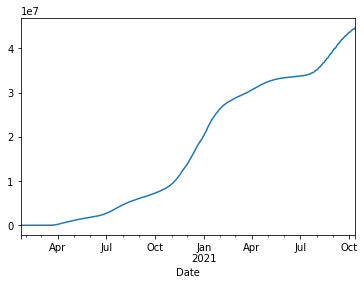

In [4]:
df = df[df['Country'] == "United States"]
usa = df.groupby('Date')['Confirmed'].sum()

# usa = usa[-300:] # get last 3 months
usa.index = pd.DatetimeIndex(usa.index).to_period('D')

usa.plot()
plt.show()

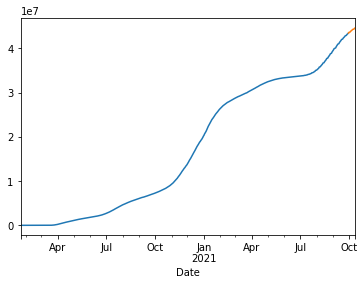

In [7]:
# Split train and test (test is the last 14 days)
usa_train = usa.loc[:'2021-09-30']
usa_test = usa.loc['2021-09-30':]

fig, ax = plt.subplots()

usa_train.plot(ax=ax)
usa_test.plot(ax=ax)
plt.show()

### 2) Test if the data is stationary

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
# Augmented Dickey–Fuller Test (ADF)
result = adfuller(usa)

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4]) 

-0.37884807653511443
0.9135709405720833
{'1%': -3.4410103235939746, '5%': -2.866243374831338, '10%': -2.5692748053002195}


The p-value is >0.05, cannot reject the null hypothesis that the data is non-stationary. Differencing or transformation is needed to make data stationary. 

ADF Statistic: -2.1098456380028403
p-value: 0.24057409534782664


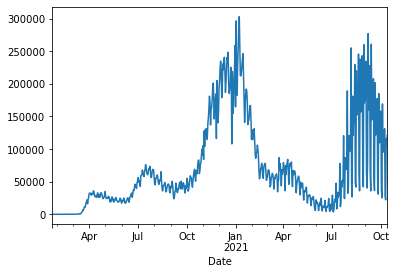

In [10]:
# Calculate the first difference of the time series
usa_stationary = usa.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(usa_stationary)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot the differenced time series
fig, ax = plt.subplots()
usa_stationary.plot(ax=ax)
plt.show()

The p-value is still >0.05. Taking the second difference:

ADF Statistic: -4.238709716927843
p-value: 0.0005662389298468463


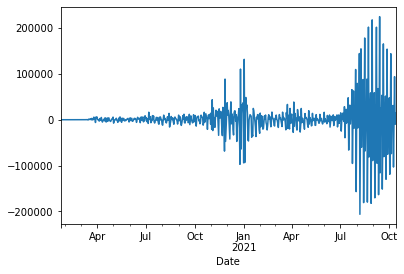

In [11]:
# Calculate the second difference of the time series
usa_stationary = usa.diff().diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(usa_stationary)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot the differenced time series
fig, ax = plt.subplots()
usa_stationary.plot(ax=ax)
plt.show()

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

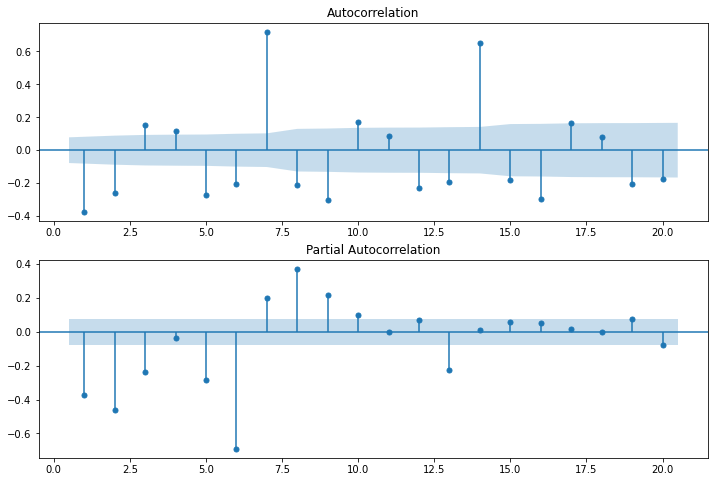

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of usa
plot_acf(usa_stationary, lags=20, zero=False, ax=ax1)

# Plot the PACF of usa
plot_pacf(usa_stationary, lags=20, zero=False, ax=ax2)

plt.show()

### 3) Search over model order using AIC and BIC

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
order_aic_bic=[]

for p in range(5):
    for q in range(5):
        try:
            # Create and fit ARMA(p,q) model
            model = SARIMAX(usa, order=(p,2,q), trend='c')
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

    p  q           AIC           BIC
18  3  3  14603.089584  14638.642634
23  4  3  14603.305076  14643.302258
24  4  4  14604.010637  14648.451950
19  3  4  14606.268427  14646.265608
14  2  4  14608.971409  14644.524459
13  2  3  14611.853543  14642.962461
9   1  4  14720.144105  14751.253024
8   1  3  14725.466425  14752.131213
4   0  4  14727.449208  14754.113995
17  3  2  14734.348023  14765.456942
3   0  3  14735.956010  14758.176666
11  2  1  14737.867192  14760.087848
21  4  1  14738.749545  14769.858464
16  3  1  14739.857316  14766.522104
12  2  2  14747.142566  14773.807353
7   1  2  14753.143166  14775.363822
2   0  2  14776.018380  14793.794905
1   0  1  14776.995714  14790.328107
6   1  1  14777.458718  14795.235243
15  3  0  14791.740839  14813.961495
20  4  0  14792.825317  14819.490104
10  2  0  14826.121757  14843.898282
22  4  2  14882.802775  14918.355825
5   1  0  14975.012505  14988.344899
0   0  0  15067.543400  15076.431662
    p  q           AIC           BIC
1

### Model diagnostics

In [ ]:
# Fit model
model = SARIMAX(usa, order=(1,2,0))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

In [ ]:
results.summary()

In [ ]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(12,8))
plt.show()

In [ ]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-14)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Confirmed']
upper_limits = confidence_intervals.loc[:,'upper Confirmed']

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(usa.index.to_timestamp(), usa, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('USA Covid Cases')
plt.legend()
plt.show()